In [1]:
#loading necessary libraries 
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa


In [ ]:
#print funciton
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


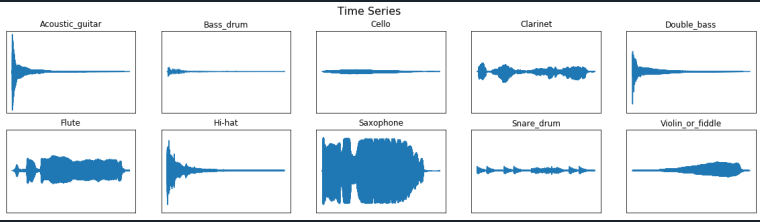

In [4]:
#result of signal
from IPython.display import Image
test = Image('1.jpg')
display(test)

In [ ]:
#fourier transform the orignal signal
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq) 

#plot the after transform
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


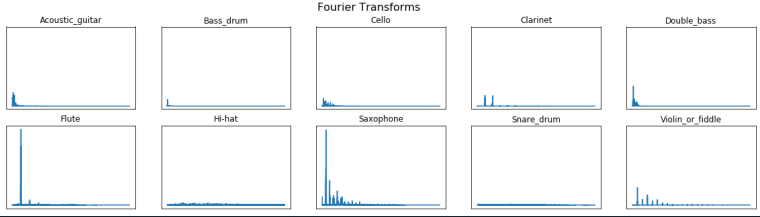

In [5]:
Image('2.jpg')

In [ ]:
# plot the spectrum 
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

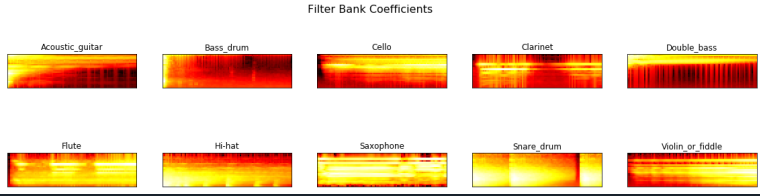

In [6]:
Image('3.jpg')

In [ ]:
#plot the mfcc spectrum
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

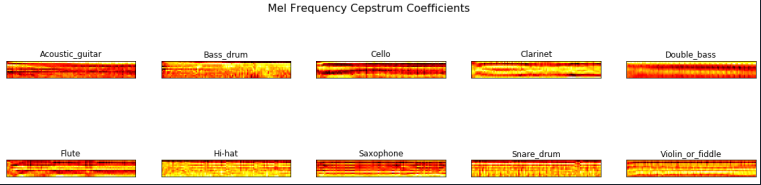

In [7]:
Image('4.jpg')

In [ ]:
# compute the mfcc spectrum
for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load('freesound-audio-tagging/wavfiles/'+wav_file,sr=44100)
    mask = envelop(signal,rate,0.0005)
    signal=signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal,rate)
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c]=bank
    mel = mfcc(signal[:rate],rate,numcep=13,nfilt=26).T
    mfccs[c] = mel

In [ ]:
#envolop the date to delete some signal that is died out
def envelop(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


In [ ]:

#saving the date to clean file
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('freesound-audio-tagging/wavfiles/'+f,sr=16000)
        mask = envelop(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f,rate=rate,data=signal[mask])

In [ ]:
#loading library for model.py

In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D,MaxPool2D, Flatten,LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config



In [ ]:
#build model using convolutional neuron network
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides =(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides =(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides =(1,1),padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))   
    model.add(Dense(64,activation='relu'))     
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer = 'adam',
                  metrics=['acc'])
    return model 

In [ ]:
#build model using recurrent neuron network
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer = 'adam',
                  metrics=['acc'])
    return model

In [ ]:
#check date to avoid build model every time.

def check_data():
    if os.path.isfile(Config.p_path):
        print('loading existing data for {} model'.format(Config.mode))
        with open(Config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [ ]:
#read date and build the model
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X=[]
    y=[]
    _min,_max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0,wav.shape[0]-Config.step)
        sample = wav[rand_index:rand_index+Config.step]
        X_sample = mfcc(sample,rate,numcep=Config.nfeat,nfilt=Config.nfilt,nfft=Config.nfft)
        _min= min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    Config.min = _min
    Config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X- _min) / (_max- _min)
    if Config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2] , 1)
    elif Config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1],X.shape[2])
    y = to_categorical(y, num_classes = 10)
    Config.data = (X,y)
    
    
    with open(Config.p_path,'wb') as handle:
        pickle.dump(Config,handle,protocol = 2)
    
    return X,y

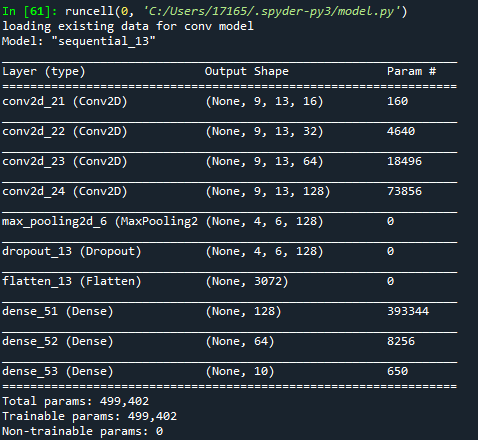

In [9]:
#result of convolutional neuron network
Image('5.jpg')

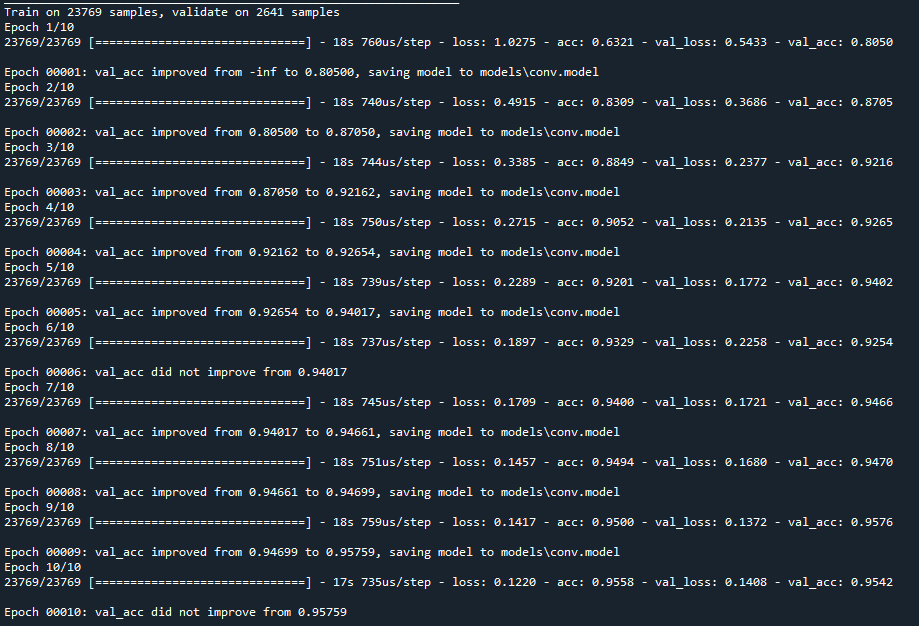

In [11]:
#the trainning result
Image('6.jpg')

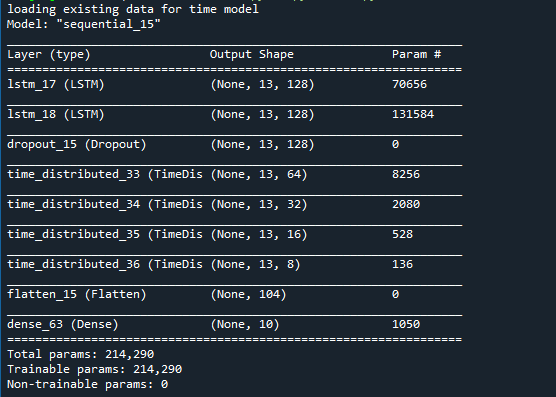

In [13]:
# the result of recurrent neuron network
Image('7.jpg')


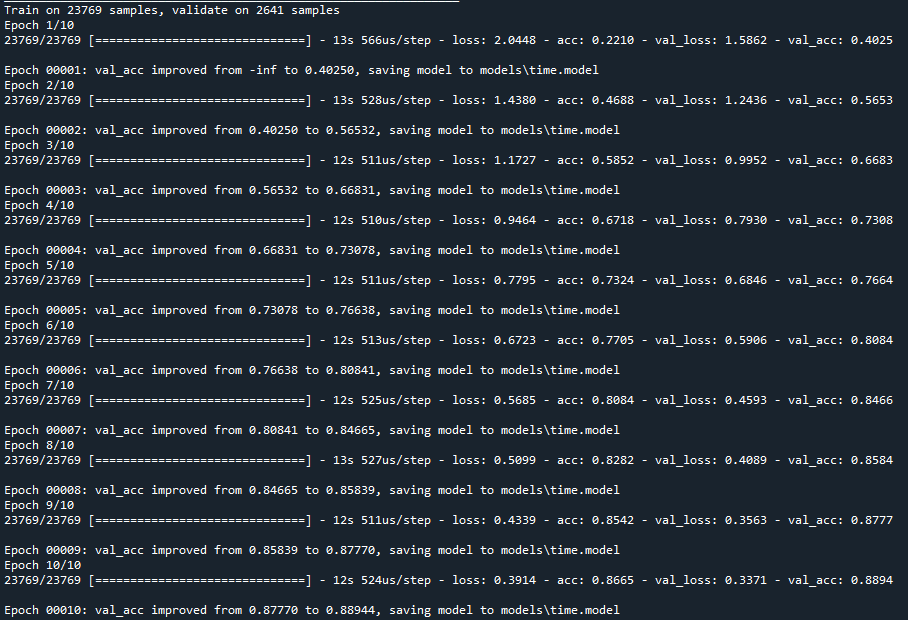

In [15]:
Image('8.png')

In [ ]:
#import library for prediction.py
import os
import pickle
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score


In [ ]:
#make prediction for all date in instrument directory
def build_prediction(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}
    print("extracting features from audio")
    
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir,fn))
        label = fn2class[fn]
        c= classes.index(label)
        y_prob = []
        for i in range(0,wav.shape[0]-config.step,config.step):
            sample = wav[i:i+config.step]
            x = mfcc(sample,rate,numcep = config.nfeat,nfilt=config.nfilt,nfft=config.nfft)
            x = (x-config.min)/(config.max-config.min)
            if config.mode =='conv':
                x=x.reshape(1,x.shape[0],x.shape[1],1)
            elif config.mode == 'time':
                x=np.expand_dims(x,axis=0)
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
            
        fn_prob[fn] = np.mean(y_prob,axis=0).flatten()
    return y_true,y_pred,fn_prob
        
df = pd.read_csv('freesound-audio-tagging/instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname,df.label))
p_path = os.path.join('pickles','conv.p')

with open(p_path,'rb') as handle:
    config = pickle.load(handle)

model = load_model(config.model_path)

y_true,y_pred, fn_prob = build_prediction('clean')

acc_score = accuracy_score(y_true = y_true, y_pred = y_pred)



In [ ]:
#save the date to prediction.csv

for i , row in df.iterrows():
    y_prob = fn_prob[row.fname]
    y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
        df.at[i,c] = p

y_pred = [classes[np.argmax(y)] for y in y_probs]

df['y_pred'] = y_pred

df.to_csv('prediciton.csv',index=False)

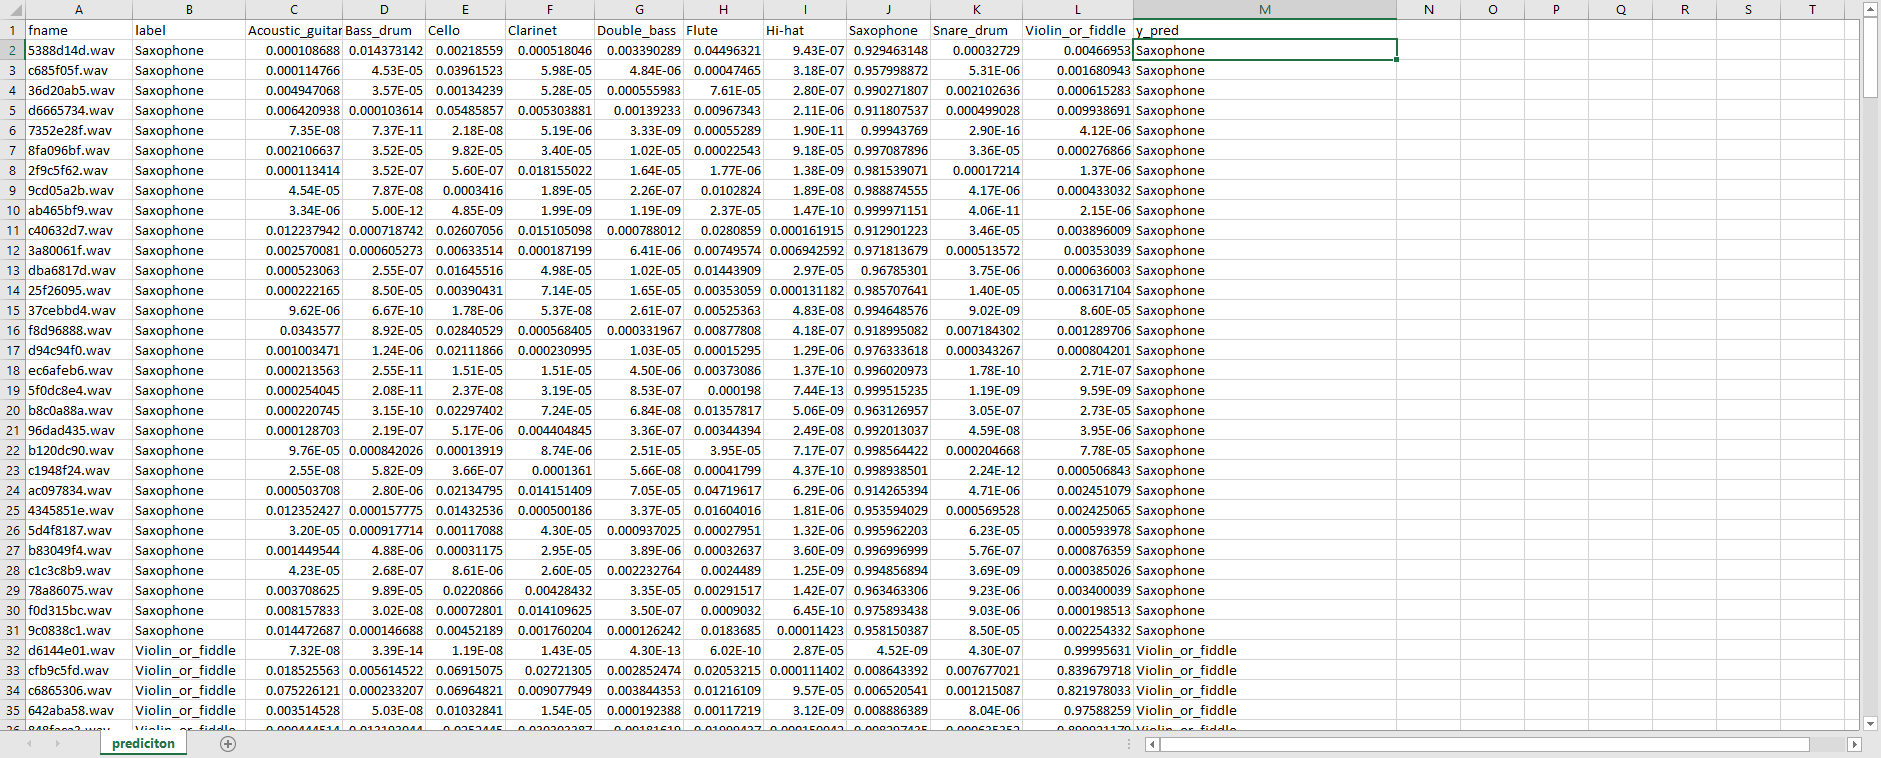

In [16]:
#the prediction result showing below
Image('9.jpg')